In [31]:
from include import *
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import GPyOpt

data is from https://www.kaggle.com/ashish8898/hand-gestures code is modified from  https://machinelearningmastery.com/5-step-life-cycle-neural-network-models-keras/ and http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [2]:
# load data
df = []
for i in range(4):
    t = np.loadtxt("data/emg-4/{}.csv".format(i), delimiter=',')
    t = pd.DataFrame(t)
    t['gesture'] = i
    df.append(t)
df = pd.concat(df).reset_index(drop=True)
# creatue dummy variables
df = pd.merge(df, pd.get_dummies(df['gesture'], drop_first=True, prefix='g'), left_index=True, right_index=True)

In [3]:
# data splitting
X = df.iloc[:, :65].values
y = df.iloc[:, -3:].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25)

In [4]:
# construct a neural network
model = Sequential()
model.add(Dense(30, input_dim=65, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

In [16]:
# define domains of parameters to tune
domain = [{'name': 'epochs', 'type': 'discrete', 'domain': range(50)},
          {'name': 'batch_size', 'type': 'discrete', 'domain': range(1000)}]

In [24]:
# define objective function
def obj(parameters):
    parameters = parameters[0]
    epochs, batch_size = parameters
    X_tr1, X_tr2, y_tr1, y_tr2 = train_test_split(X_tr, y_tr, test_size=0.25)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_tr1, y_tr1, epochs=int(epochs), batch_size=int(batch_size), verbose=0)
    scores = model.evaluate(X_tr2, y_tr2)
    return scores[0]

In [25]:
# initialize an optimizer
opt = GPyOpt.methods.BayesianOptimization(f=obj, domain=domain, verbosity=0)

2190/2190 [==============================] - 1s 399us/step


In [26]:
# run optimizer
opt.run_optimization(max_iter=50, max_time=1200)

2190/2190 [==============================] - 1s 590us/step


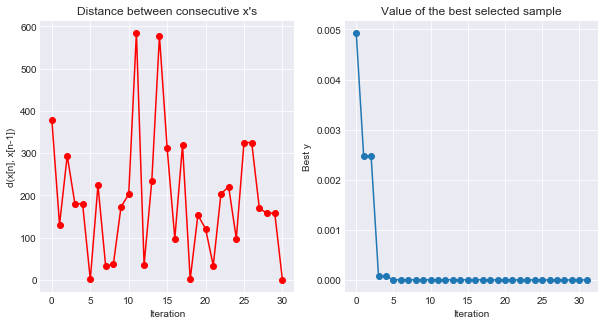

In [27]:
opt.plot_convergence()

In [36]:
print('best epochs = {}, best batch_size = {}'.format(int(opt.x_opt[0]), int(opt.x_opt[1])))

best epochs = 43, best batch_size = 661


In [28]:
# fit the best model
model.fit(X_tr, y_tr, epochs=int(opt.x_opt[0]), batch_size=int(opt.x_opt[1]), verbose=0) 

In [29]:
# aggregate score on testing set
scores = model.evaluate(X_te, y_te)

2920/2920 [==============================] - 0s 87us/step


In [30]:
print("{}: {:.4f}%".format(model.metrics_names[1], scores[1]*100.0))

acc: 97.6484%
